# Ensemble Anomaly Detection

**Мета:** Об'єднати результати всіх методів в єдиний risk score.

## Методи (5 детекторів):
1. **Rule-based** (45 rules) — процедурні порушення
2. **Statistical** (Benford, Z-score) — числові аномалії
3. **Isolation Forest** — глобальні outliers (PyOD) + value_vs_cpv_median
4. **LOF** — локальні аномалії портретів замовників (aggregated)
5. **Network Analysis** — мережевий аналіз (картелі, монополії)

## Ensemble підхід:
- Weighted voting: кожен метод голосує з вагою
- Consensus: скільки методів flagged тендер
- Final risk score: нормалізована комбінація

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data_loader import load_tenders, load_bids, load_buyers, load_suppliers, load_bidders
from src.detectors import (
    RuleBasedDetector,
    StatisticalDetector,
    PyODDetector,
    AggregatedPyOD,
    NetworkAnalysisDetector,
    EnsembleDetector,
)

# ============================================================
# CONFIGURATION
# ============================================================
YEARS = [2022, 2023, 2024, 2025]
CONTAMINATION = 0.05
# ============================================================

# Create output directories
Path('../results/figures/ensemble').mkdir(parents=True, exist_ok=True)
Path('../results').mkdir(parents=True, exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"Configuration: YEARS={YEARS}, CONTAMINATION={CONTAMINATION}")

Configuration: YEARS=[2022, 2023, 2024, 2025], CONTAMINATION=0.05


## 1. Завантаження даних

In [2]:
print("Loading data...")
tenders = load_tenders(years=YEARS)
bids = load_bids(years=YEARS)
buyers = load_buyers()
suppliers = load_suppliers()
bidders = load_bidders()

print(f"\nDataset:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Bids: {len(bids):,}")
print(f"  Buyers: {len(buyers):,}")
print(f"  Suppliers: {len(suppliers):,}")
print(f"  Bidders: {len(bidders):,}")

Loading data...
Scanning 2022...
Scanning 2023...
Scanning 2024...
Scanning 2025...
Loaded 12,877,960 records
Scanning bids 2022...
Scanning bids 2023...
Scanning bids 2024...
Scanning bids 2025...
Loaded 2,639,473 bids
Loaded buyers: 35,995
Loaded suppliers: 358,376
Loaded bidders: 72,291

Dataset:
  Tenders: 12,877,960
  Bids: 2,639,473
  Buyers: 35,995
  Suppliers: 358,376
  Bidders: 72,291


## 2. Run All Detectors

In [3]:
# 1. Rule-based
print("="*60)
print("1. RULE-BASED DETECTOR")
print("="*60)
rule_detector = RuleBasedDetector()
rule_results = rule_detector.detect(tenders, buyers_df=buyers, bids_df=bids)
print(f"\nRule-based anomalies (score >= 6): {(rule_results['rule_risk_score'] >= 6).sum():,}")

1. RULE-BASED DETECTOR
Processing 12,877,960 tenders...
Step 1/4: Computing aggregations...
  Computing CPV stats...
  Computing buyer stats...
  Computing supplier stats...
  Computing pair stats...
  Aggregations complete.
Step 2/4: Merging reference data...
Step 3/4: Applying 45 rules...
  Applied 44 rules successfully.
Step 4/4: Computing risk levels and summary...
Detection complete!

Rule-based anomalies (score >= 6): 1,882,544


In [4]:
# 2. Statistical
print("="*60)
print("2. STATISTICAL DETECTOR")
print("="*60)
stat_detector = StatisticalDetector()
stat_results = stat_detector.detect(tenders, bids_df=bids)
print(f"\nStatistical anomalies (score >= 3): {(stat_results['stat_score'] >= 3).sum():,}")

2. STATISTICAL DETECTOR
Processing 12,877,960 tenders...
Step 1/5: Computing value outliers (Z-score, IQR)...
Step 2/5: Analyzing price patterns...
Step 3/5: Running Benford's Law analysis...
    Testing Benford per buyer...
    Buyers tested: 22,334, anomalies: 7,640
    Testing Benford per supplier...
    Suppliers tested: 72,202, anomalies: 1,992
Step 4/5: Analyzing bid spreads...
Step 5/5: Computing market concentration...
Statistical screening complete!

Statistical anomalies (score >= 3): 1,481,633


In [5]:
# 3. Isolation Forest (via PyODDetector)
print("="*60)
print("3. ISOLATION FOREST")
print("="*60)

if_detector = PyODDetector(
    algorithm="iforest",
    contamination=CONTAMINATION,
    random_state=42,
)
if_results = if_detector.fit_detect(tenders)

# Rename columns for ensemble compatibility
if_results = if_results.rename(columns={"score": "if_score", "anomaly": "if_anomaly"})

print(f"IF anomalies: {if_results['if_anomaly'].sum():,}")

# Feature importance
fi = if_detector.feature_importances()
if fi:
    print("\nFeature importances:")
    for feat, imp in fi.items():
        print(f"  {feat}: {imp:.4f}")

3. ISOLATION FOREST
PyOD Detector: IFOREST
  Isolation Forest - isolates anomalies using random trees
Processing 12,877,960 tenders...
Step 1/3: Preparing features...
  Features: 9
Step 2/3: Preprocessing...
  Shape: (12877960, 9)
Step 3/3: Fitting IFOREST...

IFOREST complete!
  Anomalies: 643,896 (5.00%)
IF anomalies: 643,896

Feature importances:
  value_vs_cpv_median: 0.3250
  tender_value: 0.3112
  price_change_pct: 0.1126
  number_of_tenderers: 0.0660
  is_q4: 0.0571
  is_december: 0.0437
  is_weekend: 0.0312
  is_single_bidder: 0.0292
  is_competitive: 0.0240


In [6]:
# 4. LOF (aggregated buyer portraits)
print("="*60)
print("4. LOF (aggregated buyer portraits)")
print("="*60)

# Detect anomalous buyers using LOF on aggregated portraits
agg_lof = AggregatedPyOD(algorithm="lof", contamination=CONTAMINATION)
buyer_lof = agg_lof.detect_buyers(tenders)

print(f"\nAnomalous buyers: {buyer_lof['anomaly'].sum():,} / {len(buyer_lof):,}")

# Map buyer anomalies back to tenders
anomalous_buyers = set(buyer_lof[buyer_lof['anomaly'] == 1]['buyer_id'])
lof_results = tenders[['tender_id', 'buyer_id']].copy()
lof_results['lof_anomaly'] = lof_results['buyer_id'].isin(anomalous_buyers).astype(int)

# Map LOF score from buyer to tender
score_map = buyer_lof.set_index('buyer_id')['score']
lof_results['lof_score'] = lof_results['buyer_id'].map(score_map).fillna(0)
lof_results = lof_results.drop(columns=['buyer_id'])

n_flagged = lof_results['lof_anomaly'].sum()
print(f"LOF anomalies (tender-level): {n_flagged:,} / {len(lof_results):,} ({n_flagged/len(lof_results)*100:.1f}%)")

4. LOF (aggregated buyer portraits)
AggregatedPyOD (LOF): Detecting anomalous BUYERS...
  Computing buyer features from tenders...
  Features: ['single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_tenders', 'avg_value', 'total_value', 'cpv_concentration', 'avg_award_days', 'weekend_rate', 'value_variance_coeff', 'q4_rate']
  Buyers: 35,995
  Anomalies: 1,800 (5.0%)

Anomalous buyers: 1,800 / 35,995
LOF anomalies (tender-level): 549,543 / 12,877,960 (4.3%)


In [7]:
# 5. Network Analysis
print("="*60)
print("5. NETWORK ANALYSIS")
print("="*60)

network_detector = NetworkAnalysisDetector(
    min_co_bids=3,
    min_contracts=3,
    min_community_size=3,
    # Stricter anomaly thresholds to reduce false positives
    suspicious_min_degree=10,
    suspicious_min_clustering=0.7,
    rotation_min_ratio=0.7,
    rotation_min_interactions=5,
    monopoly_min_ratio=0.9,
    monopoly_min_contracts=20,
    build_full_collusion=False,  # Skip slow full collusion graph
)
network_results = network_detector.fit_detect(tenders, bids_df=bids, bidders_df=bidders)
print(f"\nNetwork anomalies: {network_results['network_anomaly'].sum():,}")

5. NETWORK ANALYSIS
Processing 12,877,960 tenders...
  Competitive tenders: 575,750
  Bids in competitive: 2,054,727

Step 1/5: Building co-bidding network...
    Nodes: 20,894
    Edges: 170,763
Step 2/5: Detecting communities...
    Using igraph (fast)...
    Communities: 837
Step 3/5: Building winner-loser network...
    Nodes: 15,633
    Edges: 95,300
    Bid rotation pairs: 13615
Step 4/5: Building buyer-supplier network...
    Nodes: 198,182
    Edges: 916,277
    Monopolistic pairs (>=80%, >=10 contracts): 172
Step 5/5: Skipping full collusion graph (disabled)

Computing tender-level results...
    Suspicious suppliers: 1636
    Strict monopolistic pairs: 44
    Strict rotation pairs: 7962

Network Analysis complete!
  Tenders with network flags: 2,296,664

Network anomalies: 2,296,664


In [8]:
# Combine all results using EnsembleDetector
print("="*60)
print("COMBINING RESULTS WITH ENSEMBLE DETECTOR")
print("="*60)

ensemble_detector = EnsembleDetector(
    weights={
        'rule': 1.0,
        'stat': 0.8,
        'if': 1.0,
        'lof': 0.8,
        'network': 1.0,
    },
    consensus_threshold=2,
)

ensemble = ensemble_detector.combine(
    rule_results=rule_results,
    stat_results=stat_results,
    if_results=if_results,
    lof_results=lof_results,
    network_results=network_results,
)

print(f"\nEnsemble dataset: {len(ensemble):,} tenders")

COMBINING RESULTS WITH ENSEMBLE DETECTOR
  Rule-based: 12,877,960 tenders, 1,882,544 flagged
  Statistical: 12,877,960 tenders, 363,888 flagged
  Isolation Forest: 12,877,960 tenders, 643,896 flagged
  LOF: 12,877,960 tenders, 549,543 flagged
  Network: 12,877,960 tenders, 2,296,664 flagged

Combining 5 methods: ['rule', 'stat', 'if', 'lof', 'network']

Ensemble complete!
  Critical (5/5 methods): 49,154
  High (2+/5 methods): 372,067

Ensemble dataset: 12,877,960 tenders


In [9]:
# Scores are already normalized by EnsembleDetector
print("Score columns in ensemble results:")
print([col for col in ensemble.columns if 'score' in col])

Score columns in ensemble results:
['rule_score', 'stat_score', 'if_score', 'lof_score', 'network_score', 'ensemble_score']


## 5. Compute Ensemble Score

In [10]:
# EnsembleDetector computes scores and consensus automatically
# ensemble_score, consensus_count, consensus_pct, ensemble_anomaly, ensemble_risk_level

print("WEIGHTS:", ensemble_detector.weights)
print(f"\nEnsemble score stats:")
print(ensemble['ensemble_score'].describe())

WEIGHTS: {'rule': 1.0, 'stat': 0.8, 'if': 1.0, 'lof': 0.8, 'network': 1.0}

Ensemble score stats:
count    1.287796e+07
mean     1.850738e-01
std      1.039269e-01
min      4.590722e-04
25%      1.122844e-01
50%      1.673300e-01
75%      2.305858e-01
max      7.737470e-01
Name: ensemble_score, dtype: float64


In [11]:
# Risk levels are computed by EnsembleDetector
# Based on consensus_count: critical (>=75%), high (>=50%), medium (>=25%), low (<25%)

risk_dist = ensemble['ensemble_risk_level'].value_counts()
print("\nENSEMBLE RISK DISTRIBUTION:")
for level in ['critical', 'high', 'medium', 'low']:
    count = risk_dist.get(level, 0)
    pct = count / len(ensemble) * 100
    print(f"  {level:10} {count:>10,} ({pct:>5.2f}%)")


ENSEMBLE RISK DISTRIBUTION:
  critical       49,154 ( 0.38%)
  high          322,913 ( 2.51%)
  medium        737,024 ( 5.72%)
  low        11,768,869 (91.39%)


## 6. Consensus Analysis

In [12]:
# Consensus breakdown (5 methods)
n_methods = len(ensemble_detector.methods_used)
print(f"CONSENSUS BREAKDOWN ({n_methods} methods: {ensemble_detector.methods_used}):")

consensus_dist = ensemble['consensus_count'].value_counts().sort_index()
for count, num in consensus_dist.items():
    pct = num / len(ensemble) * 100
    methods = f"{count}/{n_methods} methods"
    print(f"  {methods}: {num:>10,} ({pct:>5.2f}%)")

# Critical: most methods agree
critical_threshold = int(n_methods * 0.75)  # 75%+ methods
critical_consensus = ensemble[ensemble['consensus_count'] >= critical_threshold]
print(f"\nCRITICAL ({critical_threshold}+ of {n_methods} methods): {len(critical_consensus):,} tenders")

CONSENSUS BREAKDOWN (5 methods: ['rule', 'stat', 'if', 'lof', 'network']):
  0/5 methods:  8,673,581 (67.35%)
  1/5 methods:  3,095,288 (24.04%)
  2/5 methods:    737,024 ( 5.72%)
  3/5 methods:    322,913 ( 2.51%)
  4/5 methods:     47,310 ( 0.37%)
  5/5 methods:      1,844 ( 0.01%)

CRITICAL (3+ of 5 methods): 372,067 tenders


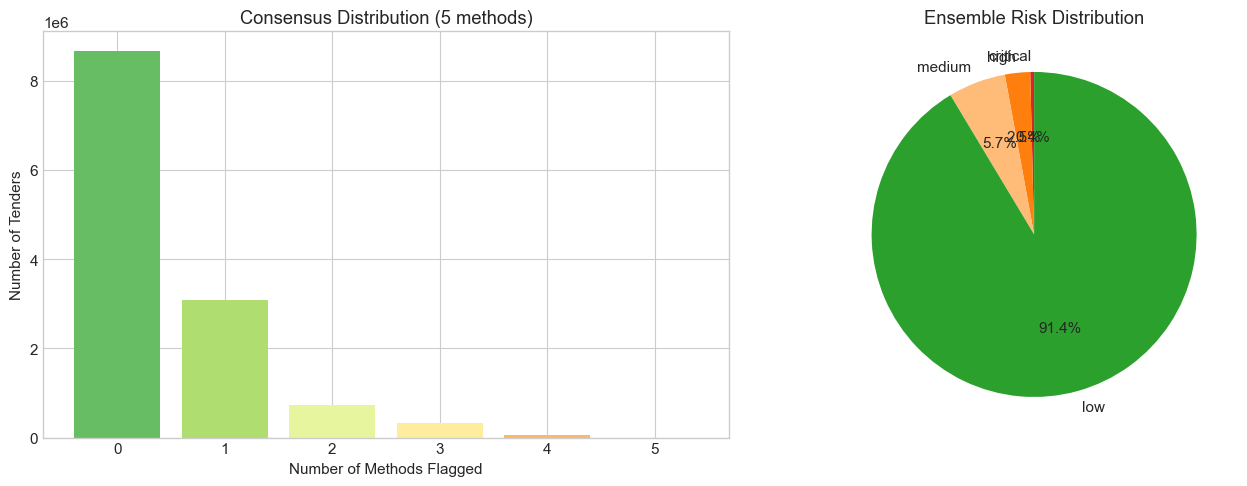

In [13]:
# Visualize consensus
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Consensus distribution
n_methods = len(ensemble_detector.methods_used)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, n_methods + 1))
axes[0].bar(consensus_dist.index, consensus_dist.values, color=colors[:len(consensus_dist)])
axes[0].set_xlabel('Number of Methods Flagged')
axes[0].set_ylabel('Number of Tenders')
axes[0].set_title(f'Consensus Distribution ({n_methods} methods)')
axes[0].set_xticks(range(n_methods + 1))

# Risk level pie
risk_colors = {'critical': '#d62728', 'high': '#ff7f0e', 'medium': '#ffbb78', 'low': '#2ca02c'}
risk_order = ['critical', 'high', 'medium', 'low']
risk_values = [risk_dist.get(r, 0) for r in risk_order]
axes[1].pie(risk_values, labels=risk_order, colors=[risk_colors[r] for r in risk_order],
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Ensemble Risk Distribution')

plt.tight_layout()
plt.savefig('../results/figures/ensemble/consensus_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Method Contribution Analysis

In [14]:
# Method contribution analysis using EnsembleDetector
print("METHOD STATISTICS:")
print(ensemble_detector.method_summary().to_string(index=False))

# Correlation matrix
print("\nSCORE CORRELATION MATRIX:")
corr_matrix = ensemble_detector.correlation_matrix()
print(corr_matrix.round(3).to_string())

# Agreement matrix (Jaccard similarity)
print("\nANOMALY AGREEMENT MATRIX (Jaccard):")
agreement_matrix = ensemble_detector.agreement_matrix()
print(agreement_matrix.round(3).to_string())

METHOD STATISTICS:
 method  anomalies  anomaly_pct  mean_score  median_score
   rule    1882544        14.62      0.1504        0.1364
   stat     363888         2.83      0.0322        0.0000
     if     643896         5.00      0.2115        0.1179
    lof     549543         4.27      0.5000        0.5000
network    2296664        17.83      0.0636        0.0000

SCORE CORRELATION MATRIX:
               rule_score  stat_score  if_score  lof_score  network_score
rule_score          1.000       0.098     0.331      0.033          0.066
stat_score          0.098       1.000     0.652      0.072          0.255
if_score            0.331       0.652     1.000      0.061          0.289
lof_score           0.033       0.072     0.061      1.000          0.002
network_score       0.066       0.255     0.289      0.002          1.000

ANOMALY AGREEMENT MATRIX (Jaccard):
                 rule_anomaly  stat_anomaly  if_anomaly  lof_anomaly  network_anomaly
rule_anomaly            1.000         0

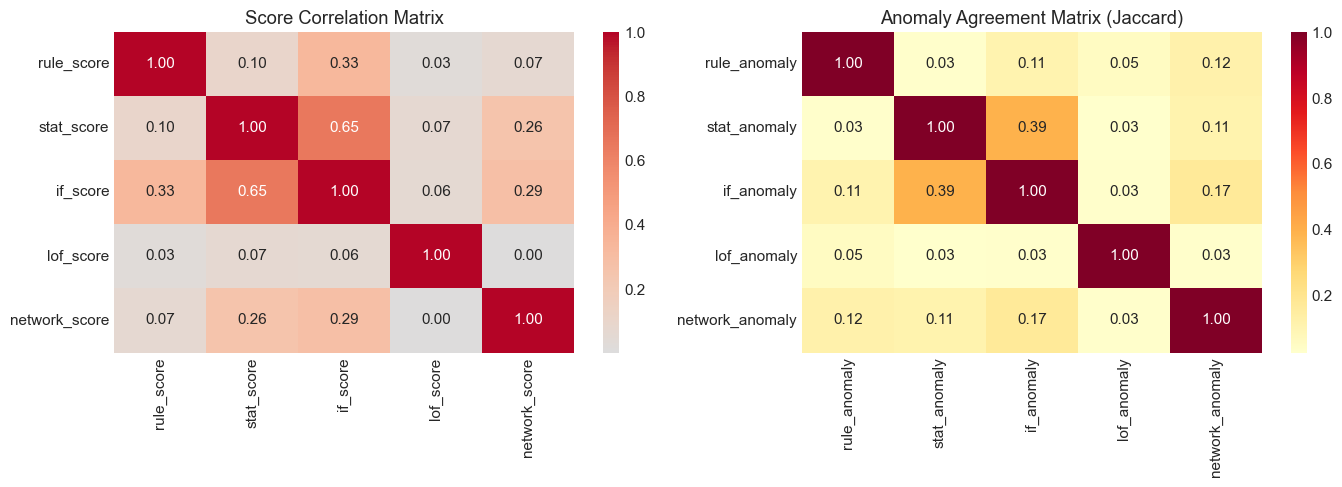

In [15]:
# Visualize agreement matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
ax = axes[0]
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Score Correlation Matrix')

# Agreement heatmap (Jaccard)
ax = axes[1]
sns.heatmap(agreement_matrix.astype(float), annot=True, fmt='.2f', cmap='YlOrRd', ax=ax)
ax.set_title('Anomaly Agreement Matrix (Jaccard)')

plt.tight_layout()
plt.savefig('../results/figures/ensemble/method_agreement.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Critical Tenders Analysis

In [16]:
# Get critical tenders (using EnsembleDetector helper)
critical_tenders = ensemble_detector.get_critical_tenders()
normal_tenders = ensemble[ensemble['consensus_count'] == 0]

# Merge with tender details
critical_with_details = critical_tenders.merge(
    tenders[['tender_id', 'tender_value', 'is_single_bidder', 'is_competitive']],
    on='tender_id', how='left'
)
normal_with_details = normal_tenders.merge(
    tenders[['tender_id', 'tender_value', 'is_single_bidder', 'is_competitive']],
    on='tender_id', how='left'
)

print("="*60)
print("CRITICAL TENDERS CHARACTERISTICS")
print("="*60)

print(f"\n{'Metric':<30} {'Critical':>15} {'Normal':>15}")
print("-"*60)

# Value
c_mean = critical_with_details['tender_value'].mean()
n_mean = normal_with_details['tender_value'].mean()
print(f"{'Mean tender value (M UAH)':<30} {c_mean/1e6:>15,.2f} {n_mean/1e6:>15,.2f}")

c_med = critical_with_details['tender_value'].median()
n_med = normal_with_details['tender_value'].median()
print(f"{'Median tender value (K UAH)':<30} {c_med/1e3:>15,.1f} {n_med/1e3:>15,.1f}")

# Competition
c_sb = critical_with_details['is_single_bidder'].mean()
n_sb = normal_with_details['is_single_bidder'].mean()
print(f"{'Single bidder rate (%)':<30} {c_sb*100:>15.1f} {n_sb*100:>15.1f}")

c_comp = critical_with_details['is_competitive'].mean()
n_comp = normal_with_details['is_competitive'].mean()
print(f"{'Competitive rate (%)':<30} {c_comp*100:>15.1f} {n_comp*100:>15.1f}")

CRITICAL TENDERS CHARACTERISTICS

Metric                                Critical          Normal
------------------------------------------------------------
Mean tender value (M UAH)                17.90            0.05
Median tender value (K UAH)              480.0             4.0
Single bidder rate (%)                    24.0             0.4
Competitive rate (%)                      72.8             0.3


In [17]:
# Procurement method distribution
print("\nPROCUREMENT METHOD:")

# Merge with tenders to get procurement method
critical_methods = critical_tenders.merge(tenders[['tender_id', 'procurement_method']], on='tender_id')
normal_methods = normal_tenders.merge(tenders[['tender_id', 'procurement_method']], on='tender_id')

critical_method_dist = critical_methods['procurement_method'].value_counts(normalize=True) * 100
normal_method_dist = normal_methods['procurement_method'].value_counts(normalize=True) * 100

for method in critical_method_dist.index:
    c_pct = critical_method_dist.get(method, 0)
    n_pct = normal_method_dist.get(method, 0)
    ratio = c_pct / n_pct if n_pct > 0 else 0
    print(f"  {method}: {c_pct:.1f}% (vs {n_pct:.1f}% normal) - {ratio:.1f}x")


PROCUREMENT METHOD:
  open: 60.3% (vs 0.5% normal) - 114.2x
  selective: 36.6% (vs 0.1% normal) - 298.0x
  limited: 3.2% (vs 99.3% normal) - 0.0x


In [18]:
# Year distribution
print("\nYEAR DISTRIBUTION:")

critical_years = critical_tenders.merge(tenders[['tender_id', 'year']], on='tender_id')
critical_year_dist = critical_years['year'].value_counts().sort_index()

for year, count in critical_year_dist.items():
    total_year = len(tenders[tenders['year'] == year])
    pct = count / total_year * 100
    print(f"  {year}: {count:,} ({pct:.2f}% of year)")


YEAR DISTRIBUTION:
  2022: 5,675 (0.24% of year)
  2023: 9,844 (0.28% of year)
  2024: 15,858 (0.47% of year)
  2025: 17,777 (0.49% of year)


## 9. Top Risky Entities

In [19]:
# Top buyers by critical tender count
print("TOP 10 BUYERS BY CRITICAL TENDERS:")

critical_full = critical_tenders.merge(
    tenders[['tender_id', 'buyer_id', 'supplier_id', 'tender_value']], 
    on='tender_id', how='left'
)

top_buyers_critical = critical_full.groupby('buyer_id').agg({
    'tender_id': 'count',
    'tender_value': 'sum',
    'ensemble_score': 'mean'
}).sort_values('tender_id', ascending=False).head(10)

top_buyers_critical = top_buyers_critical.reset_index().merge(
    buyers[['buyer_id', 'buyer_name', 'buyer_region']], on='buyer_id', how='left'
)

for _, row in top_buyers_critical.iterrows():
    name = str(row['buyer_name'])[:50] if pd.notna(row['buyer_name']) else 'N/A'
    print(f"  {row['tender_id']:>5,} tenders | {row['tender_value']/1e6:>10,.1f}M UAH | {name}")

TOP 10 BUYERS BY CRITICAL TENDERS:
    978 tenders |   52,111.4M UAH | Приватне акціонерне товариство "Укргідроенерго"
    828 tenders |    1,794.7M UAH | ФІЛІЯ «ВІДОКРЕМЛЕНИЙ ПІДРОЗДІЛ  «ХМЕЛЬНИЦЬКА АТОМН
    774 tenders |    2,999.3M UAH | Філія «ВП «Рівненська АЕС» АТ «НАЕК «Енергоатом»
    713 tenders |   38,900.4M UAH | Акціонерне товариство "Укртрансгаз"
    443 tenders |    2,731.8M UAH | Львівське міське комунальне підприємство "Львіввод
    410 tenders |   59,419.5M UAH | Державне підприємство Міністерства оборони України
    385 tenders |    1,306.8M UAH | ГОЛОВНИЙ ЦЕНТР ПІДГОТОВКИ ОСОБОВОГО СКЛАДУ ДЕРЖАВН
    378 tenders |    3,857.4M UAH | ФІЛІЯ «ВІДОКРЕМЛЕНИЙ ПІДРОЗДІЛ  «ПІВДЕННОУКРАЇНСЬК
    377 tenders |       40.7M UAH | НАЦІОНАЛЬНИЙ УНІВЕРСИТЕТ "ПОЛТАВСЬКА ПОЛІТЕХНІКА І
    314 tenders |    1,862.5M UAH | ДЕРЖАВНА УСТАНОВА "НАУКОВО-ПРАКТИЧНИЙ МЕДИЧНИЙ ЦЕН


In [20]:
# Top suppliers by critical tender count
print("\nTOP 10 SUPPLIERS BY CRITICAL TENDERS:")

top_suppliers_critical = critical_full.groupby('supplier_id').agg({
    'tender_id': 'count',
    'tender_value': 'sum',
    'ensemble_score': 'mean'
}).sort_values('tender_id', ascending=False).head(10)

top_suppliers_critical = top_suppliers_critical.reset_index().merge(
    suppliers[['supplier_id', 'supplier_name']], on='supplier_id', how='left'
)

for _, row in top_suppliers_critical.iterrows():
    name = str(row['supplier_name'])[:50] if pd.notna(row['supplier_name']) else 'N/A'
    print(f"  {row['tender_id']:>5,} tenders | {row['tender_value']/1e6:>10,.1f}M UAH | {name}")


TOP 10 SUPPLIERS BY CRITICAL TENDERS:
  1,007 tenders |      800.4M UAH | Невідокремлений структурний підрозділ ТОВ "Епіцент
    808 tenders |    1,692.6M UAH | ТОВ "СТМ-Фарм"
    735 tenders |    8,544.8M UAH | Оборонний постачальник
    631 tenders |      449.3M UAH | ТОВ "ТВГ УКРАЇНСЬКИЙ ПАПІР"
    469 tenders |    1,418.3M UAH | Товариство з обмеженою відповідальністю "Медичний 
    385 tenders |    1,751.3M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЯСНО+"
    371 tenders |    1,648.1M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ПОЛТАВАЕН
    358 tenders |    2,397.6M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ  МИКОЛАЇВС
    285 tenders |       52.1M UAH | ПІДПРИЄМСТВО ОБ'ЄДНАННЯ ГРОМАДЯН (РЕЛІГІЙНОЇ ОРГАН
    267 tenders |      489.1M UAH | ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРА ВІН


## 10. Save Results

In [21]:
# Generate explanations for critical tenders
print("Generating explanations...")

ensemble_detector.results = ensemble  # ensure results are set
explanations = ensemble_detector.generate_explanations(
    tenders_df=tenders,
    rule_results=rule_results,
    network_results=network_results,
    buyer_portraits=buyers,
)
ensemble["explanation"] = explanations

# Show examples
print("\nExample explanations (5/5 consensus):")
mask_5 = ensemble["consensus_count"] == 5
examples = ensemble.loc[mask_5, ["tender_id", "ensemble_score", "explanation"]].head(5)
for _, row in examples.iterrows():
    print(f"\n  {row['tender_id'][:16]}... (score={row['ensemble_score']:.3f})")
    print(f"  {row['explanation']}")

# Save results
print("\n" + "="*60)
print("Saving results...")

score_cols = [col for col in ensemble.columns if 'score' in col]
anomaly_cols = [col for col in ensemble.columns if 'anomaly' in col]
output_cols = ['tender_id'] + score_cols + anomaly_cols + ['consensus_count', 'consensus_pct', 'ensemble_risk_level']

# Critical tenders WITH explanation + tender details
critical_tenders = ensemble_detector.get_critical_tenders().copy()
critical_tenders["explanation"] = ensemble.loc[critical_tenders.index, "explanation"].values

critical_export = critical_tenders[output_cols + ['explanation']].merge(
    tenders[['tender_id', 'buyer_id', 'supplier_id', 'tender_value', 'award_value',
             'procurement_method', 'main_cpv_code', 'published_date']],
    on='tender_id', how='left'
).merge(
    buyers[['buyer_id', 'buyer_name']], on='buyer_id', how='left'
).merge(
    suppliers[['supplier_id', 'supplier_name']], on='supplier_id', how='left'
)
critical_export.to_csv('../results/critical_tenders.csv', index=False)
print(f"Saved: results/critical_tenders.csv ({len(critical_export):,} rows)")

# Summary
summary = ensemble_detector.summary()
summary.to_csv('../results/ensemble_summary.csv', index=False)
print(f"Saved: results/ensemble_summary.csv")

Generating explanations...
Generating explanations for flagged tenders...
  Building explanations for 1,109,091 tenders...
  Done. 1,109,091 explanations generated.

Example explanations (5/5 consensus):

  00076e8bfa064ab4... (score=0.693)
  Консенсус: 5/5 (Правила(0.45), Статистика(0.78), IForest(1.00), LOF(0.97), Мережа(0.33)) | Правила: no_enquiries, close_to_winner, identical_bids, bid_near_estimate, heterogeneous_supplier, same_day_same_supplier | Мережа: ротація перемог | Портрет: diversity=0.00, competitive=0%

  001b973e41e7471b... (score=0.558)
  Консенсус: 5/5 (Правила(0.32), Статистика(0.22), IForest(0.96), LOF(0.97), Мережа(0.33)) | Правила: high_limited_usage, single_bidder, q4_rush, cross_region_single_bidder | Мережа: ротація перемог | Портрет: diversity=0.00, competitive=0%

  0053d7d9c466461d... (score=0.557)
  Консенсус: 5/5 (Правила(0.27), Статистика(0.22), IForest(0.99), LOF(1.00), Мережа(0.33)) | Правила: single_bidder, heterogeneous_supplier, q4_rush, cross_regio

## 11. Summary

In [22]:
print("="*60)
print("ENSEMBLE SUMMARY")
print("="*60)

print(f"\nDataset: {len(ensemble):,} tenders ({YEARS[0]}-{YEARS[-1]})")
print(f"\nMethods combined ({len(ensemble_detector.methods_used)}):")
for method in ensemble_detector.methods_used:
    anomaly_col = f"{method}_anomaly"
    if anomaly_col in ensemble.columns:
        count = ensemble[anomaly_col].sum()
        print(f"  {method}: {count:,} anomalies")

print(f"\nENSEMBLE RISK LEVELS:")
for level in ['critical', 'high', 'medium', 'low']:
    count = risk_dist.get(level, 0)
    pct = count / len(ensemble) * 100
    print(f"  {level:10} {count:>10,} ({pct:>5.2f}%)")

print(f"\nCRITICAL TENDERS (ensemble_risk_level == 'critical'):")
print(f"  Count: {len(critical_tenders):,}")
if len(critical_with_details) > 0:
    print(f"  Total value: {critical_with_details['tender_value'].sum()/1e9:.2f}B UAH")
    print(f"  Mean value: {critical_with_details['tender_value'].mean()/1e6:.2f}M UAH")
    print(f"  Single bidder rate: {critical_with_details['is_single_bidder'].mean()*100:.1f}%")

print("\n" + "="*60)

ENSEMBLE SUMMARY

Dataset: 12,877,960 tenders (2022-2025)

Methods combined (5):
  rule: 1,882,544 anomalies
  stat: 363,888 anomalies
  if: 643,896 anomalies
  lof: 549,543 anomalies
  network: 2,296,664 anomalies

ENSEMBLE RISK LEVELS:
  critical       49,154 ( 0.38%)
  high          322,913 ( 2.51%)
  medium        737,024 ( 5.72%)
  low        11,768,869 (91.39%)

CRITICAL TENDERS (ensemble_risk_level == 'critical'):
  Count: 49,154
  Total value: 880.07B UAH
  Mean value: 17.90M UAH
  Single bidder rate: 24.0%



## Висновки

### Ensemble підхід (5 методів):
- **Rule-based** — процедурні порушення (45 rules), anomaly = high/critical risk level
- **Statistical** — числові аномалії (Benford, Z-score, HHI)
- **Isolation Forest** — глобальні outliers (tree-based, tender-level, з value_vs_cpv_median)
- **LOF** — локальні аномалії агрегованих портретів замовників (buyer-level → mapped to tenders)
- **Network Analysis** — картелі, монополії, bid rotation

### Scoring:
- **Weighted score**: зважена комбінація нормалізованих scores
- **Consensus voting**: кількість методів, що flagged тендер
- **Risk levels**: critical (>=75%), high (>=50%), medium (>=25%), low (<25%)

### Ключові результати:
- **Critical** (більшість методів згодні) — найвища впевненість для аудиту
- Методи доповнюють один одного (низька кореляція)
- Різні типи аномалій покриваються різними методами
- LOF працює на рівні інформаційних портретів замовників (36K), покриваючи всі 12.9M тендерів
- IForest враховує `value_vs_cpv_median` — відношення вартості до медіани категорії CPV

### Збережені файли:
- `results/critical_tenders.csv` — critical тендери з explanation колонкою
- `results/ensemble_summary.csv` — summary statistics